# **The Battle of Neighbourhoods: Fukuoka**

####IBM Data Science Professional Certification - Capstone Project

[IBM Data Science](https://www.coursera.org/professional-certificates/ibm-data-science)

*Author: E. Malamura*

*Publication date: July 21, 2021*

**Introduction**

This project is the capstone assignment for the IBM Data Science Professional Certification on Coursera. The goal of the assignment was to come up with an idea to leverage the Foursquare API location data to explore or compare neighborhoods or a city of choice and develop a report outlining the business problem, dataset, data analysis methodology, results, observations, and conclusions. As the city of choice I picked the city of Fukuoka, Japan.


The goal of this analysis is to identify a good location for opening a new coffee shop in Fukuoka city, such that:

a) the area has a decent foot traffic,

b) the area is popular among people, who are most likely to be active customers of a coffee shop. In this analysis we will focus mainly on the young population of Fukuoka City, trying to detect locations of their interest and gathering,

c) the location has few coffee shops opened yet, that would give some competitive advantage to a new venue.

The results of this analysis will be useful for  entrepreneurs, who are planning to open a coffee shop venue in the city and thus looking for a promising location.


**Data Description**

Instead of analysis of districts and neighbourhoods of the city by their names and official borders, we will use train stations as centers of neighbourhoods. That sounds reasonable for Japanese cities, due to high levels of development and popularity of public transport.

* The list of names of all stations (in Japanese) of 3 operators are found and scraped from a website of local ‘yellow pages’. 
* Geographical coordinates of each station were scraped from corresponding wikipedia pages.
* The load (foot traffic) of every station is obtained from another source of regional statistical data in CSV format.
* We used the Foursquare API to gather information about venues in the vicinity (500m radius) of each train station.

We were interested in 3 large categories of venues, which are: Coffee shops; Colleges and universities; Arts and entertainment venues

The first category will give us information about possible competitors in the vicinity of a station. The other two categories may give us insights about places of gathering of young audience, that is the primary target group of customers, as it is stated in Introduction.


#### **Part #1: Scraping location data from web**

Set up libraries for scraping

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re
import regex

Scraping names of train stations in Japanese

In [2]:
# get html and create a soup object
url = 'https://www.mapion.co.jp/phonebook/M12001/40130/'

headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36',}
data  = requests.get(url, headers=headers).text
soup = BeautifulSoup(data,"html5lib")

In [3]:
# scrape names of stations to a list
stations = []
for link in soup.findAll('a', attrs={'href': re.compile("^/phonebook")}):
    link_title = link.get('title')
    if link_title:
      if link_title[-1] == '駅':
        stations.append(link_title)

# create the main dataframe
df = pd.DataFrame()
df['Station'] = stations
df

,Station
0,中洲川端駅
1,天神南駅
2,西鉄福岡駅
3,天神駅
4,祇園駅
...,...
64,奈多駅
65,西戸崎駅
66,唐の原駅
67,三苫駅


Scraping geographical coordinates and english names of stations from wikipedia

In [4]:
# make urls of station pages in wiki
df['Url'] = 'https://ja.wikipedia.org/wiki/' + df['Station']

# check correctness of urls
disambiguate_urls = []
for url in df['Url']:
  data  = requests.get(url, headers=headers).text
  soup = BeautifulSoup(data,"html5lib")
  if soup.find('a', attrs={'title': 'Wikipedia:曖昧さ回避'}):
    disambiguate_urls.append(url)

# print incorrect urls
disambiguate_urls

['https://ja.wikipedia.org/wiki/赤坂駅',
 'https://ja.wikipedia.org/wiki/藤崎駅',
 'https://ja.wikipedia.org/wiki/別府駅',
 'https://ja.wikipedia.org/wiki/大橋駅',
 'https://ja.wikipedia.org/wiki/橋本駅',
 'https://ja.wikipedia.org/wiki/高宮駅',
 'https://ja.wikipedia.org/wiki/梅林駅',
 'https://ja.wikipedia.org/wiki/金山駅',
 'https://ja.wikipedia.org/wiki/茶山駅',
 'https://ja.wikipedia.org/wiki/貝塚駅']

In [5]:
# make corrections to wrong urls - just add _(福岡県)
df.loc[df['Url'].isin(disambiguate_urls), 'Url'] +=  '_(福岡県)'

# somehow one page had no default 'disambiguation' message
# make correction for it manually
df.loc[df['Station']=='祇園駅','Url'] = 'https://ja.wikipedia.org/wiki/祇園駅_(福岡県)'

In [6]:
# scraping of coordinates and english names

latitudes = []
longitudes = []
spellings = []

for url in df['Url']:
  # scrape page
  data  = requests.get(url, headers=headers).text
  soup = BeautifulSoup(data,"html5lib")

  # grab coordinates
  latitudes.append(soup.find('span', attrs={'class': 'latitude'}).text)
  longitudes.append(soup.find('span', attrs={'class': 'longitude'}).text)
  
  # grab station name in English
  spell = soup.find('table', attrs={'class': 'infobox bordered'}).find('span').text
  spell = regex.sub('[^\p{Latin}]', u'', spell)
  spellings.append(spell)

# Add scraped data to our main dataframe
df['EngName'] = spellings
df['Latitude'] = latitudes
df['Longitude'] = longitudes

df.head()

,Station,Url,EngName,Latitude,Longitude
0,中洲川端駅,https://ja.wikipedia.org/wiki/中洲川端駅,Nakasukawabata,北緯33度35分41.94秒,東経130度24分23.77秒
1,天神南駅,https://ja.wikipedia.org/wiki/天神南駅,Tenjinminami,北緯33度35分17.51秒,東経130度24分6.22秒
2,西鉄福岡駅,https://ja.wikipedia.org/wiki/西鉄福岡駅,NishitetsuFukuokaTenjin,北緯33度35分19.6秒,東経130度23分59.6秒
3,天神駅,https://ja.wikipedia.org/wiki/天神駅,Tenjin,北緯33度35分29.36秒,東経130度23分57.69秒
4,祇園駅,https://ja.wikipedia.org/wiki/祇園駅_(福岡県),Gion,北緯33度35分38.56秒,東経130度24分52.84秒


Conversion of coordinates from Japanese DMS to decimal format

In [7]:
!pip install dms2dec
from dms2dec.dms_convert import dms2dec # for conversion of coordinates
# usage of the library is dms2dec('''33°35'38.56"E''')

# function for converting japanese DMS coordinates to Decimal coordinates
# using dms2dec library
def coordinate_cleaner(coordinate_string, hemisphere='N', valid = '0123456789.'):
  # input > '北緯33度35分38.56秒'
  # split by chinese characters > '  33 35 38.56 '
  coordinate_string = ''.join([ch if ch in valid else ' ' for ch in coordinate_string])
  # strip spaces > '33 35 38.56'
  coordinate_string = coordinate_string.strip()
  # split by inner spaces > [33, 35, 38.56]
  coordinate_string = coordinate_string.split(' ')
  # insert degrees, minutes, and seconds
  # hemisphere does not matter for Fukuoka, because both coordinates will be positive
  coordinate_string.insert(1, '°')
  coordinate_string.insert(3, "'")
  coordinate_string.insert(5,'"'+hemisphere)
  # join > 33°35'38.56"N
  coordinate_string = ''.join(coordinate_string)
  return dms2dec(coordinate_string)

# apply cleaning function
df['Latitude'] = df['Latitude'].apply(coordinate_cleaner)
df['Longitude'] = df['Longitude'].apply(coordinate_cleaner)

In [8]:
# drop duplicate records by location data
df.drop_duplicates(subset=['Latitude', 'Longitude'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Station,Url,EngName,Latitude,Longitude
0,中洲川端駅,https://ja.wikipedia.org/wiki/中洲川端駅,Nakasukawabata,33.594983,130.406603
1,天神南駅,https://ja.wikipedia.org/wiki/天神南駅,Tenjinminami,33.588197,130.401728
2,西鉄福岡駅,https://ja.wikipedia.org/wiki/西鉄福岡駅,NishitetsuFukuokaTenjin,33.588778,130.399889
3,天神駅,https://ja.wikipedia.org/wiki/天神駅,Tenjin,33.591489,130.399358
4,祇園駅,https://ja.wikipedia.org/wiki/祇園駅_(福岡県),Gion,33.594044,130.414678
...,...,...,...,...,...
61,九大学研都市駅,https://ja.wikipedia.org/wiki/九大学研都市駅,KyūdaiGakkentoshi,33.578161,130.259878
62,奈多駅,https://ja.wikipedia.org/wiki/奈多駅,Nata,33.686722,130.412500
63,西戸崎駅,https://ja.wikipedia.org/wiki/西戸崎駅,Saitozaki,33.650236,130.357825
64,唐の原駅,https://ja.wikipedia.org/wiki/唐の原駅,Tōnoharu,33.680050,130.434506


Load data on daily passengers flow for stations in fukuoka prefecture from another source

In [9]:
df_passengers = pd.read_csv('https://raw.githubusercontent.com/ibikinoradio/Coursera_Capstone/main/data/csv_pref_40_best.csv')
df_passengers

,順位,乗降客数,駅名,路線名,区分,事業者名,都道府県コード
0,1,252957,博多,鹿児島線,ＪＲ,九州旅客鉄道,40
1,2,162210,博多,1号線(空港線),公営,福岡市,40
2,3,148957,天神,1号線(空港線),公営,福岡市,40
3,4,133696,西鉄福岡(天神),天神大牟田線,民営,西日本鉄道,40
4,5,99913,姪浜,1号線(空港線),公営,福岡市,40
...,...,...,...,...,...,...,...
381,-,他路線に含む,金田,糸田線,三セク,平成筑豊鉄道,40
382,-,他路線に含む,中洲川端,2号線(箱崎線),公営,福岡市,40
383,-,他路線に含む,博多,博多南線,ＪＲ,西日本旅客鉄道,40
384,-,他路線に含む,西鉄二日市,太宰府線,民営,西日本鉄道,40


Apply some cleaning to the new data

In [10]:
# translate the columns of our interest from Japanese to English for convenience
df_passengers.rename(columns={'順位': 'Ranking',
                              '駅名': 'Station',
                              '乗降客数': 'Passengers'}, inplace=True)
df_passengers = df_passengers[['Ranking', 'Station', 'Passengers']]

# function to remove text in brackets (alternative names)
def remove_inbrackets(mystring):
  result = re.sub("[\(].*?[\)]", "", mystring)

  return result

# remove the last character 駅 from station names in the main dataset
df['Station'] = df['Station'].str[:-1]
# remove the alternative names of stations in brackets
df_passengers['Station'] = df_passengers['Station'].apply(remove_inbrackets)
df_passengers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,Ranking,Station,Passengers
0,1,博多,252957
1,2,博多,162210
2,3,天神,148957
3,4,西鉄福岡,133696
4,5,姪浜,99913
...,...,...,...
381,-,金田,他路線に含む
382,-,中洲川端,他路線に含む
383,-,博多,他路線に含む
384,-,西鉄二日市,他路線に含む


Merge data about daily passengers from the new source with the main dataframe

In [11]:
# Filter the new data by station names of Fukuoka city
df_passengers = df_passengers.loc[df_passengers['Station'].isin(df['Station'])]
# remove rows with no data
df_passengers = df_passengers[df_passengers['Ranking']!='-']

# convert passengers cout column to numeric
df_passengers['Passengers'] = pd.to_numeric(df_passengers['Passengers'])

# group station with same name (separated count for lines operated by different companies)
df_passengers = df_passengers[['Station', 'Passengers']].groupby('Station', axis=0).sum()
df_passengers.reset_index(inplace=True)

# merge station load data with the main dataframe
df = pd.merge(df, df_passengers, on='Station')

del df_passengers

df

,Station,Url,EngName,Latitude,Longitude,Passengers
0,中洲川端,https://ja.wikipedia.org/wiki/中洲川端駅,Nakasukawabata,33.594983,130.406603,38465
1,天神南,https://ja.wikipedia.org/wiki/天神南駅,Tenjinminami,33.588197,130.401728,30201
2,西鉄福岡,https://ja.wikipedia.org/wiki/西鉄福岡駅,NishitetsuFukuokaTenjin,33.588778,130.399889,133696
3,天神,https://ja.wikipedia.org/wiki/天神駅,Tenjin,33.591489,130.399358,148957
4,祇園,https://ja.wikipedia.org/wiki/祇園駅_(福岡県),Gion,33.594044,130.414678,15772
...,...,...,...,...,...,...
61,九大学研都市,https://ja.wikipedia.org/wiki/九大学研都市駅,KyūdaiGakkentoshi,33.578161,130.259878,18893
62,奈多,https://ja.wikipedia.org/wiki/奈多駅,Nata,33.686722,130.412500,2247
63,西戸崎,https://ja.wikipedia.org/wiki/西戸崎駅,Saitozaki,33.650236,130.357825,1808
64,唐の原,https://ja.wikipedia.org/wiki/唐の原駅,Tōnoharu,33.680050,130.434506,1092


#### **Part #2: Get data from Forsquare API**

Set up Forsquare API credentials

In [12]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Function for scraping data about venues of categories of our interest from Foursquare API

In [13]:
def getNearbyVenues(names, latitudes, longitudes, passengers, radius=500):

    categories = {'Education' : '4d4b7105d754a06372d81259',
                  'Entertainment' : '4d4b7104d754a06370d81259',
                  'Cafes' : '4bf58dd8d48988d1e0931735'
                  }

    venues_list=[]

    for catName, catId in categories.items():
        for name, lat, lng, psngr in zip(names, latitudes, longitudes, passengers):
                
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT,
                catId
                )
                
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng,
                psngr,
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],
                catName,
                v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude',
                  'Daily Passengers',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Subcategory']
    
    return(nearby_venues)

Get data about venues from Foursquare API

In [14]:
df = getNearbyVenues(names = df['EngName'],
                            latitudes = df['Latitude'],
                            longitudes = df['Longitude'],
                            passengers =  df['Passengers']
                            )
df

,Station,Station Latitude,Station Longitude,Daily Passengers,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Subcategory
0,Nakasukawabata,33.594983,130.406603,38465,大原簿記情報専門学校 福岡校,33.595307,130.407490,Education,Trade School
1,Nakasukawabata,33.594983,130.406603,38465,ハレンチ女学園,33.591103,130.408669,Education,Other Nightlife
2,Tenjinminami,33.588197,130.401728,30201,九州工業大学 サテライトキャンパス福岡天神,33.590090,130.400000,Education,University
3,Tenjinminami,33.588197,130.401728,30201,英進館 天神本館,33.586765,130.401039,Education,School
4,Tenjinminami,33.588197,130.401728,30201,EF Education First,33.587599,130.396708,Education,General College & University
...,...,...,...,...,...,...,...,...,...
1399,KyūdaiGakkentoshi,33.578161,130.259878,18893,marbre blanc cafe イオン伊都店,33.577047,130.258188,Cafes,Café
1400,KyūdaiGakkentoshi,33.578161,130.259878,18893,三和珈琲館 今宿店,33.581970,130.261789,Cafes,Coffee Shop
1401,Saitozaki,33.650236,130.357825,1808,sleepcoffee,33.647698,130.356676,Cafes,Coffee Shop
1402,Mitoma,33.702072,130.422544,3478,POP COFFEES,33.702350,130.424076,Cafes,Coffee Shop


#### **Part #3: Exploratory analysis**

Import visualisation tools

In [15]:
import folium
from geopy.geocoders import Nominatim

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

print(plt.style.available)
mpl.style.use('ggplot')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


Plot daily passengers flow by station

       Daily Passengers
count         62.000000
mean       28723.661290
std        62317.355973
min         1092.000000
25%         6330.000000
50%        13101.500000
75%        24421.000000
max       461079.000000


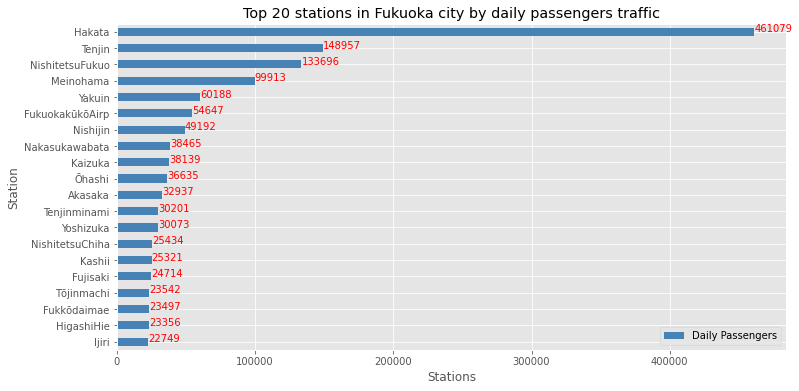

In [16]:
df_temp = df[['Station', 'Daily Passengers']].drop_duplicates(subset=['Station'])
df_temp['Station'] = df_temp['Station'].str[:15]

print(df_temp.describe())

df_temp = df_temp.set_index('Station').sort_values('Daily Passengers')[-20:]

df_temp.plot(kind='barh',figsize=(12, len(df_temp)//3), color='steelblue')
plt.xlabel('Stations')
plt.title('Top 20 stations in Fukuoka city by daily passengers traffic')

for index, value in enumerate(df_temp['Daily Passengers']):
    label = str(value)

    plt.annotate(label, xy=(value, index), color='red')

plt.show()

del df_temp

Plot number of coffee shop venues at stations

            Count
count   59.000000
mean    13.711864
std     23.969126
min      1.000000
25%      3.000000
50%      4.000000
75%     11.000000
max    100.000000


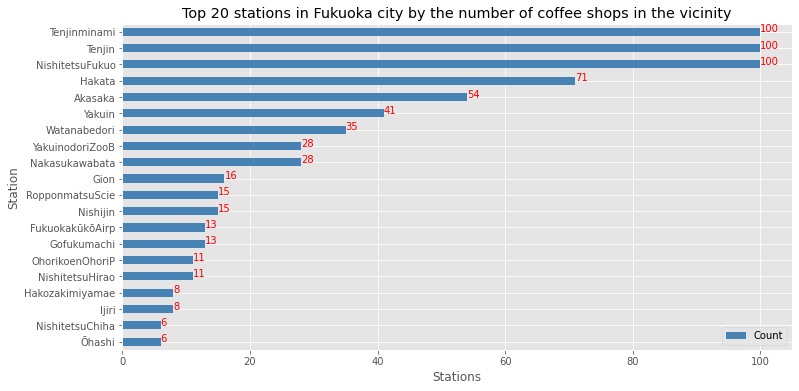

In [17]:
df_temp = df[['Station', 'Venue Category']].groupby(['Station', 'Venue Category'])['Venue Category'].count().reset_index(name="Count")
df_temp = df_temp[df_temp['Venue Category']=='Cafes'].sort_values('Count', ascending=False)
df_temp['Station'] = df_temp['Station'].str[:15]

print(df_temp.describe())

df_temp = df_temp.drop('Venue Category', 1)
df_temp = df_temp.set_index('Station').sort_values('Count')[-20:]

df_temp.plot(kind='barh',figsize=(12, len(df_temp)//3) , color='steelblue') #
plt.xlabel('Stations')
plt.title('Top 20 stations in Fukuoka city by the number of coffee shops in the vicinity')

for index, value in enumerate(df_temp['Count']): 
    label = str(value)
    plt.annotate(label, xy=(value, index), color='red')


plt.show()

del df_temp

Visualize stations and venues locations on a map with Folium

In [18]:
# location of Fukuoka city
address = 'Fukuoka, Fukuoka'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Fukuoka, Fukuoka are 33.5898988, 130.4017509.


In [19]:
# make a map
map_fukuoka = folium.Map(location=[latitude, longitude], zoom_start=12)

catColor = {'Education' : '#ff0000',
            'Entertainment' : '#c8ff00',
            'Cafes' : '#8000ff'
                  }


# add markers for venues to map
for lat, lng, label, venue in zip(df['Venue Latitude'],
                                 df['Venue Longitude'],
                                 df['Venue Subcategory'],
                                 df['Venue Category']):

    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        weight=1,
        popup=label,
        color=catColor[venue],
        fill=False,
        fill_color=catColor[venue],
        fill_opacity=0.3,
        parse_html=False).add_to(map_fukuoka)  

# add station markers to the map
df_temp = df.drop_duplicates(subset=['Station'])
for lat, lng, label in zip(df_temp['Station Latitude'],
                           df_temp['Station Longitude'],
                           df_temp['Station']):

    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=4,
        popup=label,
        rotation=0,
        radius=10,
        weight=2,
        color='green',
        fill_color='white',
        fill_opacity=0.2).add_to(map_fukuoka)

del df_temp

map_fukuoka

#### **Part #4: Clustering**

Import machine learning tools

In [20]:
from sklearn import preprocessing
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


Prepare data for clustering

In [21]:
# one hot encoding
fukuoka_onehot = pd.get_dummies(df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
fukuoka_onehot['Station'] = df['Station']
# move it to first position
fukuoka_onehot.insert(0, 'Station', fukuoka_onehot.pop('Station'))

print('Size of one-hot encoded dataframe is:', fukuoka_onehot.shape)

fukuoka_grouped = fukuoka_onehot.groupby('Station').sum().reset_index()

del fukuoka_onehot

# merge station load data with the main dataframe
fukuoka_grouped = pd.merge(fukuoka_grouped,
                            df[['Station', 'Daily Passengers']].drop_duplicates(subset=['Station']),
                              on='Station')

print('Size of grouped encoded dataframe is:', fukuoka_grouped.shape)
fukuoka_grouped.sort_values('Daily Passengers', ascending=False)

Size of one-hot encoded dataframe is: (1404, 4)
Size of grouped encoded dataframe is: (62, 5)


,Station,Cafes,Education,Entertainment,Daily Passengers
11,Hakata,71,9,18,461079
50,Tenjin,100,5,55,148957
38,NishitetsuFukuokaTenjin,100,6,46,133696
29,Meinohama,5,2,4,99913
57,Yakuin,41,5,4,60188
...,...,...,...,...,...
4,Doi,0,0,1,2963
24,KashiiMiyamae,2,2,4,2418
25,Kashiijingū,1,0,0,2033
44,Saitozaki,1,0,0,1808


Find an optimal number of clusters with KElbowVisualizer

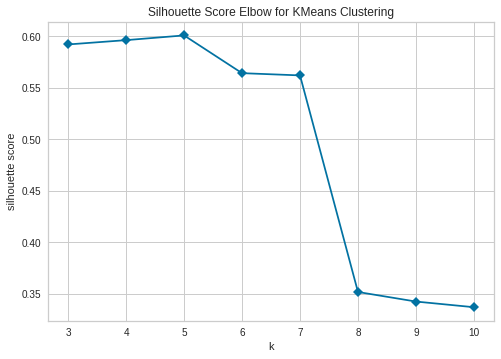

In [22]:
kclusters = (3,11)

if 'Cluster' in fukuoka_grouped.columns:
    fukuoka_grouped = fukuoka_grouped.drop('Cluster', 1)

X = fukuoka_grouped.drop('Station', 1)

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)

# run k-means clustering
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=kclusters, metric='silhouette', timings=False)

visualizer.fit(X) 
visualizer.poof()

Perform clustering with selected k

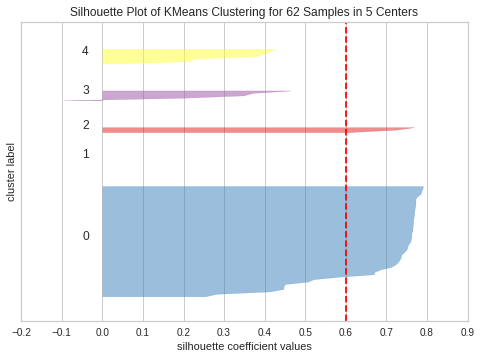

In [23]:
# Instantiate the clustering model and visualizer
kclusters = 5

model = KMeans(kclusters, random_state=0)
kmeans = SilhouetteVisualizer(model)

kmeans.fit(X)    # Fit the data to the visualizer
kmeans.poof()

Combine results for further analysis

In [24]:
fukuoka_grouped['Cluster'] = kmeans.labels_

result = pd.merge(df[['Station', 'Station Latitude', 'Station Longitude']].drop_duplicates(subset=['Station']),
                    fukuoka_grouped,
                      on='Station')
result

,Station,Station Latitude,Station Longitude,Cafes,Education,Entertainment,Daily Passengers,Cluster
0,Nakasukawabata,33.594983,130.406603,28,2,26,38465,3
1,Tenjinminami,33.588197,130.401728,100,5,39,30201,2
2,NishitetsuFukuokaTenjin,33.588778,130.399889,100,6,46,133696,2
3,Tenjin,33.591489,130.399358,100,5,55,148957,2
4,Akasaka,33.589117,130.390850,54,4,15,32937,3
...,...,...,...,...,...,...,...,...
57,Najima,33.642675,130.431731,2,0,0,2982,0
58,Kashiijingū,33.649753,130.452631,1,0,0,2033,0
59,Imajuku,33.579433,130.273561,3,0,0,10957,0
60,Saitozaki,33.650236,130.357825,1,0,0,1808,0


In [25]:
result[['Cluster', 'Cafes',	'Education',	'Entertainment',	'Daily Passengers' ]].groupby('Cluster').mean()

,Cafes,Education,Entertainment,Daily Passengers
Cluster,,,,
0,4.630435,1.760870,2.739130,15372.782609
1,71.000000,9.000000,18.000000,461079.000000
2,100.000000,5.333333,46.666667,104284.666667
3,37.200000,3.800000,10.800000,29162.800000
4,5.571429,14.714286,4.142857,21996.000000


In [26]:
result[['Station', 'Cafes',	'Education', 'Entertainment']].sum()

Station          NakasukawabataTenjinminamiNishitetsuFukuokaTen...
Cafes                                                          809
Education                                                      228
Entertainment                                                  367
dtype: object

Inspect each cluster

Cluster 0:

In [27]:
pd.set_option('display.max_rows', 10)
result[result['Cluster']==0].sort_values(by='Daily Passengers', ascending=False)

,Station,Station Latitude,Station Longitude,Cafes,Education,Entertainment,Daily Passengers,Cluster
23,Meinohama,33.583703,130.325236,5,2,4,99913,0
48,FukuokakūkōAirport,33.597078,130.448542,13,0,5,54647,0
42,Kaizuka,33.632175,130.425578,2,3,1,38139,0
29,Yoshizuka,33.607161,130.423906,4,3,5,30073,0
31,NishitetsuChihayaChihaya,33.649258,130.440164,6,1,3,25434,0
...,...,...,...,...,...,...,...,...
50,Doi,33.634994,130.466097,0,0,1,2963,0
27,KashiiMiyamae,33.654658,130.442525,2,2,4,2418,0
58,Kashiijingū,33.649753,130.452631,1,0,0,2033,0
60,Saitozaki,33.650236,130.357825,1,0,0,1808,0


Cluster 1:

In [28]:
result[result['Cluster']==1].sort_values(by='Daily Passengers', ascending=False)

,Station,Station Latitude,Station Longitude,Cafes,Education,Entertainment,Daily Passengers,Cluster
7,Hakata,33.59,130.420611,71,9,18,461079,1


Cluster 2:

In [29]:
result[result['Cluster']==2].sort_values(by='Daily Passengers', ascending=False)

,Station,Station Latitude,Station Longitude,Cafes,Education,Entertainment,Daily Passengers,Cluster
3,Tenjin,33.591489,130.399358,100,5,55,148957,2
2,NishitetsuFukuokaTenjin,33.588778,130.399889,100,6,46,133696,2
1,Tenjinminami,33.588197,130.401728,100,5,39,30201,2


Cluster 3:

In [30]:
result[result['Cluster']==3].sort_values(by='Daily Passengers', ascending=False)

,Station,Station Latitude,Station Longitude,Cafes,Education,Entertainment,Daily Passengers,Cluster
8,Yakuin,33.581925,130.401683,41,5,4,60188,3
0,Nakasukawabata,33.594983,130.406603,28,2,26,38465,3
4,Akasaka,33.589117,130.390850,54,4,15,32937,3
5,Watanabedori,33.583969,130.404844,35,5,7,7966,3
10,YakuinodoriZooBotanicalGarden,33.580406,130.396158,28,3,2,6258,3


Cluster 4:

In [31]:
result[result['Cluster']==4].sort_values(by='Daily Passengers', ascending=False)

,Station,Station Latitude,Station Longitude,Cafes,Education,Entertainment,Daily Passengers,Cluster
17,Nishijin,33.583803,130.359742,15,22,8,49192,4
20,Ōhashi,33.559203,130.426344,6,10,4,36635,4
21,Fukkōdaimae,33.698442,130.440117,2,9,3,23497,4
36,Fukudaimae,33.547469,130.362228,3,28,2,14098,4
11,MaidashikyūdaibyōinmaeMaidashiKyushuUniversity...,33.609214,130.419317,4,12,5,12551,4
18,Befu,33.574169,130.369628,5,12,1,11453,4
34,HakozakikyūdaimaeHakozakiKyushuUniversity,33.622111,130.421039,4,10,6,6546,4


Plot number of venues per station in Cluster 4

           Cafes
count   7.000000
mean    5.571429
std     4.353433
min     2.000000
25%     3.500000
50%     4.000000
75%     5.500000
max    15.000000


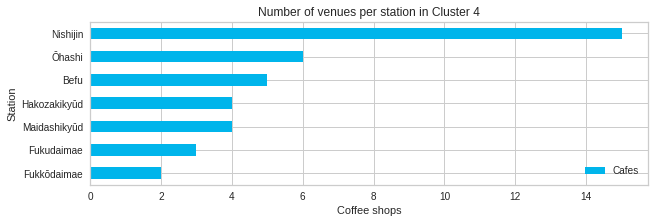

In [32]:
df_temp = result[result['Cluster']==4].sort_values(by='Cafes')
df_temp['Station'] = df_temp['Station'].str[:12]
df_temp = df_temp[['Station', 'Cafes']].set_index('Station')

print(df_temp.describe())

df_temp.plot(kind='barh',figsize=(10, 7//2), color='#00b5eb')
plt.xlabel('Coffee shops')
plt.title('Number of venues per station in Cluster 4')

plt.show()

del df_temp

Plot passenger flow per station in Cluster 4

       Daily Passengers
count           7.00000
mean        21996.00000
std         15586.42313
min          6546.00000
25%         12002.00000
50%         14098.00000
75%         30066.00000
max         49192.00000


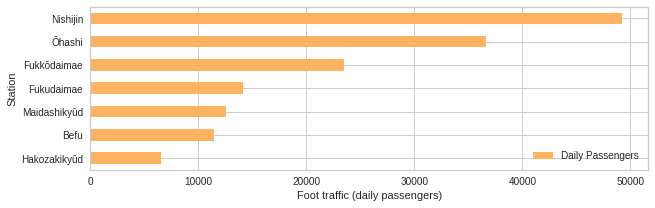

In [33]:
df_temp = result[result['Cluster']==4].sort_values(by='Daily Passengers')
df_temp['Station'] = df_temp['Station'].str[:12]
df_temp = df_temp[['Station', 'Daily Passengers']].set_index('Station')

print(df_temp.describe())

df_temp.plot(kind='barh',figsize=(10, 7//2), color='#ffb360')
plt.xlabel('Foot traffic (daily passengers)')
#plt.title('Number of venues per station in a cluster')

plt.show()

del df_temp

Visualize clusters on a map with Folium

In [34]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# ['#8000ff', '#00b5eb', '#80ffb4', '#ffb360', '#ff0000'] # red blue

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(result['Station Latitude'], result['Station Longitude'], result['Station'], result['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters